In [99]:
!pip install pmdarima

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil,sqrt,floor
from sklearn.linear_model import LinearRegression
import datetime as dt
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from pmdarima.arima import auto_arima
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [101]:
m_stock = pd.read_csv('Microsoft_Stock.csv')

In [102]:
m_stock

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438
...,...,...,...,...,...,...
1506,3/25/2021 16:00:00,235.30,236.94,231.57,232.34,34061853
1507,3/26/2021 16:00:00,231.55,236.71,231.55,236.48,25479853
1508,3/29/2021 16:00:00,236.59,236.80,231.88,235.24,25227455
1509,3/30/2021 16:00:00,233.53,233.85,231.10,231.85,24792012


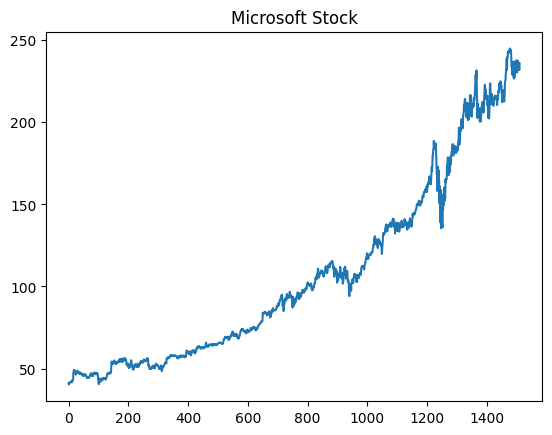

In [103]:
m_stock['Close'].plot()
plt.title('Microsoft Stock')
plt.show()

In [104]:
x = m_stock.copy()
x['Date'] = pd.to_datetime(x.Date, format = '%m/%d/%Y %H:%M:%S')
x.index = x['Date']

In [105]:
x.head()

,Date,Open,High,Low,Close,Volume
Date,,,,,,
2015-04-01 16:00:00,2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


Text(0.5, 1.0, 'History of stock prices of Microsoft')

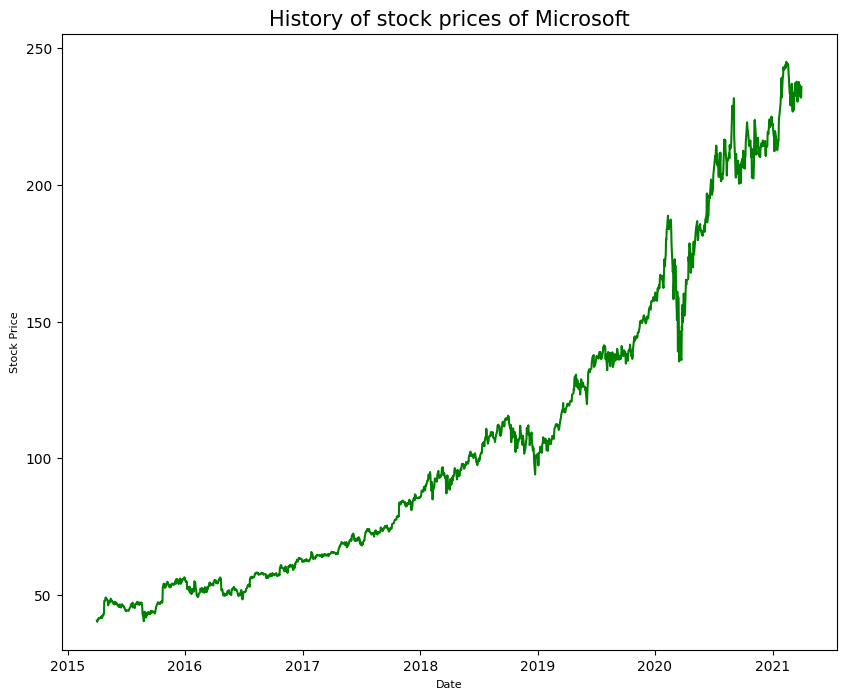

In [107]:
fig = plt.figure(figsize=(10,8))
plt.plot(x['Close'], label = 'Close Price history', color = 'green')
plt.xlabel('Date', size = 8)
plt.ylabel('Stock Price', size = 8)
plt.title('History of stock prices of Microsoft', size = 15)

In [108]:
m_stock.shape

(1511, 6)

In [109]:
m_stock[['Close']]

,Close
0,40.72
1,40.29
2,41.55
3,41.53
4,41.42
...,...
1506,232.34
1507,236.48
1508,235.24
1509,231.85


In [113]:
def moving_average(df):
  shape = df.shape[0]
  new_df = df[['Close']]
  train_data = new_df.iloc[:ceil(shape * 0.8)]
  valid_data = new_df.iloc[ceil(shape*0.8):]
  preds = []
  for i in range(0, valid_data.shape[0]):
    a = train_data['Close'][len(train_data) - valid_data.shape[0] + i:].sum() + sum(preds)
    b = a/(valid_data.shape[0])
    preds.append(b)
  rms = np.sqrt(np.mean(np.power((np.array(valid_data['Close'])-preds),2)))
  print('RMSE value on validation set:', rms)
  valid_data['Predictions'] = preds
  plt.plot(train_data['Close'])
  plt.plot(valid_data[['Close','Predictions']])
  plt.xlabel('Date',size = 20)
  plt.ylabel('Stock Price', size = 20)
  plt.title('Stock price prediction using Moving Averages', size = 20)
  plt.legend(['Training Data','Actual Data','Predicted Data'])

RMSE value on validation set: 69.38484924906464


<ipython-input-113-f3548eb6dd29>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions'] = preds


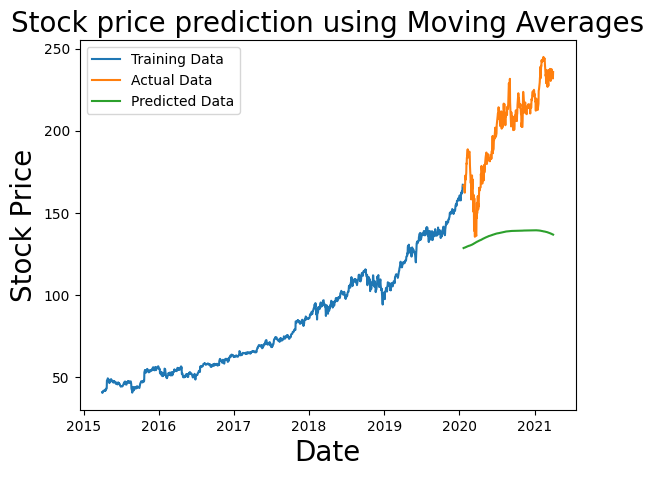

In [114]:
moving_average(x)

RMSE value on validation set :  56.96175596453776


<ipython-input-115-326b2dedd593>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions'] = preds


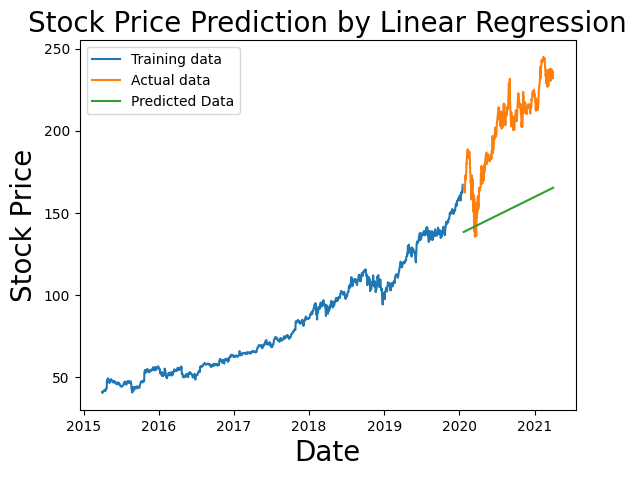

In [115]:
# def linear_regression(df):
shape = x.shape[0]
df_new = x[['Close']]
train_data = df_new.iloc[:ceil(shape*0.8)]
valid_data = df_new.iloc[ceil(shape*0.8):]
# print(train_data.head())
# print("Shape of Training data :", train_data.shape)
# print("Shape of Validation data :", valid_data.shape)
train = train_data.reset_index()
valid = valid_data.reset_index()
# print("hello")
# print(train.head())
x_train = train['Date'].map(dt.datetime.toordinal)
y_train = train[['Close']]
x_valid = valid['Date'].map(dt.datetime.toordinal)
y_valid = valid[['Close']]
# print("hello")
# print(x_train.head())
model = LinearRegression()
# print(y_train)
# print(np.array(x_train).reshape(-1,1))
model.fit(np.array(x_train).reshape(-1,1), y_train)
preds = model.predict(np.array(x_valid).reshape(-1,1))
rms = np.sqrt(np.mean(np.power((np.array(valid_data['Close']) - preds),2)))
print("RMSE value on validation set : ", rms)
valid_data['Predictions'] = preds
plt.plot(train_data['Close'])
plt.plot(valid_data[['Close','Predictions']])
plt.xlabel('Date', size = 20)
plt.ylabel('Stock Price', size = 20)
plt.title('Stock Price Prediction by Linear Regression', size = 20)
plt.legend(['Training data','Actual data','Predicted Data'])

In [116]:
valid_data

,Close,Predictions
Date,,
2020-01-21 16:00:00,166.50,138.312013
2020-01-22 16:00:00,165.70,138.373992
2020-01-23 16:00:00,166.72,138.435971
2020-01-24 16:00:00,165.04,138.497950
2020-01-27 16:00:00,162.28,138.683887
...,...,...
2021-03-25 16:00:00,232.34,164.900992
2021-03-26 16:00:00,236.48,164.962971
2021-03-29 16:00:00,235.24,165.148908


Training data shape :  (1209, 1)
Validation data shape : (302, 1)
          0
0  0.000000
1  0.000571
2  0.002854
3  0.003425
4  0.003995
RMS value on validation set:  119.88877743381019


<ipython-input-117-b76335337135>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions'] = preds


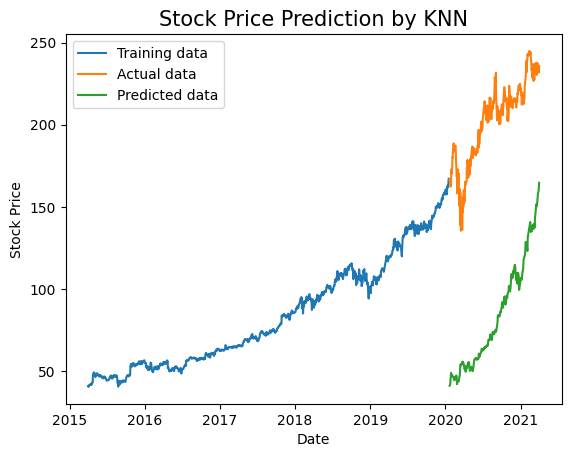

In [117]:
shape = x.shape[0]
new_df = x[['Close']]
new_df.head()
train_data = new_df.iloc[:ceil(shape*0.8)]
valid_data = new_df.iloc[ceil(shape*0.8) :]
print("Training data shape : ", train_data.shape)
print("Validation data shape :", valid_data.shape)
train = train_data.reset_index()
valid = valid_data.reset_index()
x_train = train['Date'].map(dt.datetime.toordinal)
y_train = train[['Close']]
x_valid = valid['Date'].map(dt.datetime.toordinal)
y_valid = valid[['Close']]
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(np.array(x_train).reshape(-1,1))
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(np.array(x_valid).reshape(-1,1))
x_valid = pd.DataFrame(x_valid_scaled)
print(x_train.head())
parameters = {'n_neighbors' : [2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, parameters, cv=5)
model.fit(x_train,y_train)
preds = model.predict(x_valid)
rms = np.sqrt(np.mean(np.power((np.array(y_valid) - preds),2)))
print('RMS value on validation set: ', rms)
valid_data['Predictions'] = preds
plt.plot(train_data['Close'])
plt.plot(valid_data[['Close','Predictions']])
plt.xlabel('Date', size = 10)
plt.ylabel('Stock Price',size = 10)
plt.title('Stock Price Prediction by KNN',size = 15)
plt.legend(['Training data','Actual data','Predicted data'])


In [118]:
x.head()

,Date,Open,High,Low,Close,Volume
Date,,,,,,
2015-04-01 16:00:00,2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


In [120]:
x.head()

,Date,Open,High,Low,Close,Volume
Date,,,,,,
2015-04-01 16:00:00,2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


In [121]:
shape = x.shape[0]
new_df = x[['Close']]
data = new_df.values
train = new_df[:ceil(shape*0.8)]
valid = new_df[ceil(shape*0.8) :]
print("Shape of training set :",train.shape)
print("Shape of validation set:",valid.shape)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)


Shape of training set : (1209, 1)
Shape of validation set: (302, 1)


In [122]:
scaled_data.shape

(1511, 1)

In [123]:
x_train = []
y_train = []
for i in range(40,len(train)):
  x_train.append(scaled_data[i-40 : i, 0])
  y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [124]:
x_train.shape

(1169, 40)

In [125]:
x_train[0]

array([0.00210064, 0.        , 0.00615535, 0.00605765, 0.00552027,
       0.00581339, 0.00698583, 0.00718124, 0.00664387, 0.00962384,
       0.00913532, 0.00649731, 0.01279922, 0.01148021, 0.01319003,
       0.01489985, 0.0370298 , 0.03781143, 0.0433317 , 0.04284319,
       0.0407914 , 0.04088911, 0.03883732, 0.0357108 , 0.02926234,
       0.03131412, 0.03644358, 0.0345872 , 0.0344895 , 0.03585735,
       0.04118222, 0.03913043, 0.03771373, 0.03561309, 0.03561309,
       0.03483146, 0.03229116, 0.03077675, 0.03575965, 0.03497802])

In [126]:
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))

In [127]:
x_train.shape

(1169, 40, 1)

In [128]:
model = Sequential()
model.add(LSTM(units = 40, return_sequences = True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(units = 40))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam')
model.fit(x_train, y_train, epochs = 10, batch_size = 1, verbose = 2)

Epoch 1/10
1169/1169 - 44s - loss: 8.4015e-04 - 44s/epoch - 38ms/step
Epoch 2/10
1169/1169 - 25s - loss: 2.6704e-04 - 25s/epoch - 22ms/step
Epoch 3/10
1169/1169 - 25s - loss: 2.3004e-04 - 25s/epoch - 22ms/step
Epoch 4/10
1169/1169 - 30s - loss: 2.0497e-04 - 30s/epoch - 26ms/step
Epoch 5/10
1169/1169 - 26s - loss: 1.4744e-04 - 26s/epoch - 22ms/step
Epoch 6/10
1169/1169 - 26s - loss: 1.3546e-04 - 26s/epoch - 22ms/step
Epoch 7/10
1169/1169 - 26s - loss: 1.1568e-04 - 26s/epoch - 22ms/step
Epoch 8/10
1169/1169 - 25s - loss: 9.3237e-05 - 25s/epoch - 22ms/step
Epoch 9/10
1169/1169 - 25s - loss: 1.0065e-04 - 25s/epoch - 21ms/step
Epoch 10/10
1169/1169 - 25s - loss: 9.1998e-05 - 25s/epoch - 22ms/step


In [129]:
len(new_df)
print(len(valid))

302


In [130]:
inputs = new_df[len(new_df) - len(valid) - 40 :].values

In [131]:
inputs = inputs.reshape(-1,1)

In [132]:
inputs

array([[149.62],
       [149.48],
       [149.59],
       [151.23],
       [152.03],
       [152.32],
       [151.38],
       [149.55],
       [149.31],
       [149.85],
       [149.93],
       [151.75],
       [151.75],
       [151.13],
       [151.7 ],
       [153.24],
       [154.53],
       [155.53],
       [154.69],
       [154.37],
       [155.71],
       [157.41],
       [157.41],
       [157.38],
       [158.67],
       [158.96],
       [157.59],
       [157.7 ],
       [160.62],
       [158.62],
       [159.03],
       [157.58],
       [160.09],
       [162.09],
       [161.34],
       [163.28],
       [162.13],
       [163.18],
       [166.17],
       [167.1 ],
       [166.5 ],
       [165.7 ],
       [166.72],
       [165.04],
       [162.28],
       [165.46],
       [168.04],
       [172.78],
       [170.23],
       [174.38],
       [180.12],
       [179.9 ],
       [183.63],
       [183.89],
       [188.7 ],
       [184.44],
       [184.71],
       [183.71],
       [185.35

In [133]:
inputs = scaler.fit_transform(inputs)
x_test = []
for i in range(40, inputs.shape[0]):
  x_test.append(inputs[i-40 :i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
closing_price = model.predict(x_test)


10/10 [==============================] - 1s 17ms/step


In [134]:
closing_price

array([[0.2836686 ],
       [0.28162944],
       [0.2761616 ],
       [0.28283948],
       [0.27283654],
       [0.25296804],
       [0.27168074],
       [0.29293165],
       [0.32994977],
       [0.316849  ],
       [0.34525752],
       [0.3907791 ],
       [0.39415708],
       [0.42394277],
       [0.4284648 ],
       [0.46802318],
       [0.43697354],
       [0.44191313],
       [0.4350865 ],
       [0.44966063],
       [0.46538916],
       [0.46687305],
       [0.44549897],
       [0.40156054],
       [0.34358904],
       [0.31924832],
       [0.33057585],
       [0.2465421 ],
       [0.2602632 ],
       [0.3353754 ],
       [0.28682986],
       [0.32124093],
       [0.29361716],
       [0.25722593],
       [0.17838383],
       [0.22944477],
       [0.1922216 ],
       [0.09367026],
       [0.18777865],
       [0.07237411],
       [0.10119051],
       [0.07539232],
       [0.07863693],
       [0.04873823],
       [0.02915199],
       [0.09264782],
       [0.1086057 ],
       [0.165

In [135]:
closing_price = scaler.inverse_transform(closing_price)
rms = np.sqrt(np.mean(np.power((valid - closing_price),2)))
print('RMS value on validation set : ', rms)
valid['Predictions'] = closing_price

RMS value on validation set :  Close    4.776777
dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
<ipython-input-135-f8bcbd4615cd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


In [136]:
valid

,Close,Predictions
Date,,
2020-01-21 16:00:00,166.50,166.501572
2020-01-22 16:00:00,165.70,166.278137
2020-01-23 16:00:00,166.72,165.679031
2020-01-24 16:00:00,165.04,166.410721
2020-01-27 16:00:00,162.28,165.314697
...,...,...
2021-03-25 16:00:00,232.34,231.971664
2021-03-26 16:00:00,236.48,229.518875
2021-03-29 16:00:00,235.24,234.885269


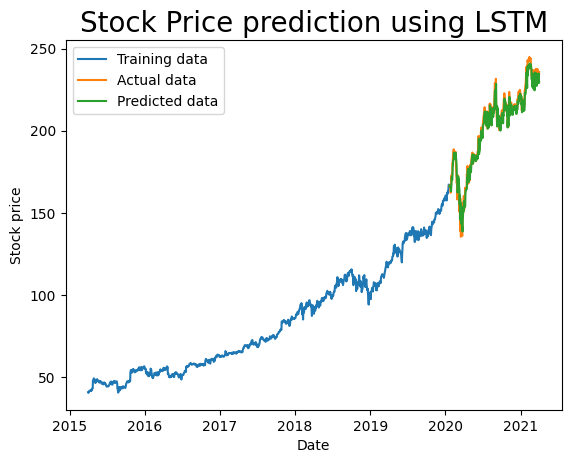

In [137]:
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.xlabel('Date', size = 10)
plt.ylabel('Stock price', size = 10)
plt.title('Stock Price prediction using LSTM', size = 20)
plt.legend(['Training data', 'Actual data','Predicted data'])